In [1]:
!pip install transformers sentence-transformers gradio faiss-cpu nltk requests beautifulsoup4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [ ]:
import nltk
nltk.download('punkt_tab')

In [4]:
import requests
import re
import time
import random
import numpy as np
import faiss
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import gradio as gr

# ====================== Web Scraper ======================
class WebScraper:
    def __init__(self, url_list, min_words=30000):
        self.url_queue = url_list.copy()
        self.collected_text = []
        self.total_words = 0
        self.min_words = min_words
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        }

    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s.,;?!-]', '', text)
        return text.lower().strip()

    def extract_content(self, soup):
        for tag in soup(['header', 'footer', 'nav', 'script', 'style', 'aside', 'form', 'figure']):
            tag.decompose()
        main_content = soup.find('main') or soup.find('article') or soup.find('div', class_=re.compile('content|main'))
        return ' '.join(p.get_text() for p in (main_content or soup).find_all(['p', 'h1', 'h2', 'h3'])) if main_content else ''

    def scrape_page(self, url):
        try:
            time.sleep(2 + random.random() * 3)
            response = requests.get(url, headers=self.headers, timeout=15)
            soup = BeautifulSoup(response.content, 'lxml')
            raw_text = self.extract_content(soup)
            clean_text = self.clean_text(raw_text)
            return clean_text
        except Exception as e:
            print(f"Error scraping {url}: {str(e)[:100]}")
            return ""

    def run(self):
        while self.url_queue and self.total_words < self.min_words:
            url = self.url_queue.pop(0)
            text = self.scrape_page(url)
            word_count = len(text.split())

            if word_count > 100:
                self.collected_text.append(text)
                self.total_words += word_count
                print(f"Added {word_count} words from {url} (Total: {self.total_words})")

        return self.collected_text

# ====================== Text Processor ======================
class TextProcessor:
    def __init__(self, chunk_size=250):
        self.chunk_size = chunk_size

    def process(self, texts):
        chunks = []
        for text in texts:
            sentences = sent_tokenize(text)
            current_chunk = []
            current_word_count = 0
            for sentence in sentences:
                words = sentence.split()
                if current_word_count + len(words) > self.chunk_size and current_chunk:
                    chunks.append(' '.join(current_chunk))
                    current_chunk = []
                    current_word_count = 0
                current_chunk.append(sentence)
                current_word_count += len(words)
            if current_chunk:
                chunks.append(' '.join(current_chunk))
        return chunks

# ====================== Local RAG System ======================
class LocalRAG:
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        self.index = None
        self.chunks = []
        self.tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-beta")
        self.model = AutoModelForCausalLM.from_pretrained(
            "HuggingFaceH4/zephyr-7b-beta",
            device_map="auto",
            torch_dtype=torch.float16
        )

    def create_index(self, chunks):
        self.chunks = chunks
        embeddings = self.embedder.encode(chunks, convert_to_tensor=True).cpu().numpy().astype('float32')
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

    def retrieve(self, query, top_k=3):
        query_embed = self.embedder.encode([query]).astype('float32')
        distances, indices = self.index.search(query_embed, top_k)
        return [self.chunks[i] for i in indices[0]]

    def generate(self, context, question):
        prompt = f"""<|system|>
Use this context to answer the question:
{''.join(context)}
</s>
<|user|>
{question}</s>
<|assistant|>"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(
            inputs.input_ids,
            max_new_tokens=256,
            temperature=0.7,
            do_sample=True,
            pad_token_id=self.tokenizer.eos_token_id
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True).split("<|assistant|>")[-1].strip()

# ====================== Main Workflow ======================
websites = [
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://www.ibm.com/topics/machine-learning",
    "https://www.techtarget.com/searchenterpriseai/definition/machine-learning-ML"
]

scraper = WebScraper(websites, min_words=30000)
scraped_texts = scraper.run()

processor = TextProcessor(chunk_size=200)
chunks = processor.process(scraped_texts)
print(f"\nCreated {len(chunks)} text chunks")

rag = LocalRAG()
rag.create_index(chunks)
print("RAG system ready!")

# ====================== Gradio Interface ======================
def answer_question(question):
    context = rag.retrieve(question)
    answer = rag.generate(context, question)
    joined_context = "\n\n".join(context)
    return f"📘 **Context**:\n{joined_context}\n\n🤖 **Answer**:\n{answer}"

iface = gr.Interface(
    fn=answer_question,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question about machine learning...", label="Your Question"),
    outputs=gr.Textbox(label="Answer with Context"),
    title="RAG-based ML QA System",
    description="Ask a question and get answers using Retrieval-Augmented Generation (RAG) from scraped machine learning articles."
)

iface.launch()


Added 8591 words from https://en.wikipedia.org/wiki/Machine_learning (Total: 8591)
Added 2821 words from https://www.ibm.com/topics/machine-learning (Total: 11412)
Added 3432 words from https://www.techtarget.com/searchenterpriseai/definition/machine-learning-ML (Total: 14844)

Created 81 text chunks


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

RAG system ready!
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a5e39fd93595e42db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


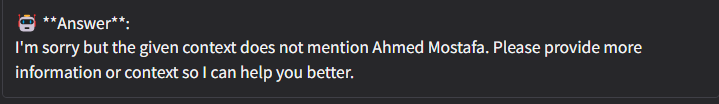